# *Import all relevant libraries for video and image processing*

In [19]:
# Import relevant libraries for video and image processing
from IPython.display import HTML
from moviepy.editor import VideoFileClip
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline



## All functions to process image

In [37]:
# This function converts an image to grayscale
def convert_to_greyscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# This function applies a Canny transform to an image
def apply_canny_transform(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

# This function applies a Gaussian blur to an image
def apply_gaussian_blur(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# This function applies a mask to an image
def apply_mask(image, vertices):
    #define a blank mask to start 
    mask = np.zeros_like(image)

    #define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# This function detects lines using Hough Line Transformation
def hough_line_transformation(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    averaged_lines = average(image, lines)
    displaylines = display_lines(image, averaged_lines)
    return displaylines

# This function draws lines on an image
def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    #make sure array isn't empty
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            #draw lines on a black image
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 7)
    return lines_image

def average(image, lines):
    left = []
    right = []

    if lines is not None:
      for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_int = parameters[1]
        #lines on the right have positive slope, and lines on the left have neg slope
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
            
    #takes average among all the columns (column0: slope, column1: y_int)
    right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    #create lines based on averages calculates
    left_line = make_points(image, left_avg)
    right_line = make_points(image, right_avg)
    return np.array([left_line, right_line])

def make_points(image, average, line_length=2/5):
    slope, y_int = average
    y1 = image.shape[0]
    y2 = int(y1 * (line_length))
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

# This function merges the lines with the original image
def merge_lines_with_image(image, lines):
    return cv2.addWeighted(image, 0.8, lines, 1, 0)



## Test to see if image is able to be read

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


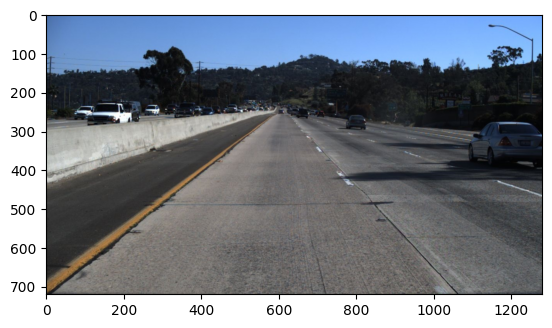

In [21]:
image = mpimg.imread('../Dataset/Input/15.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Test if image is able to be converted into greyscale

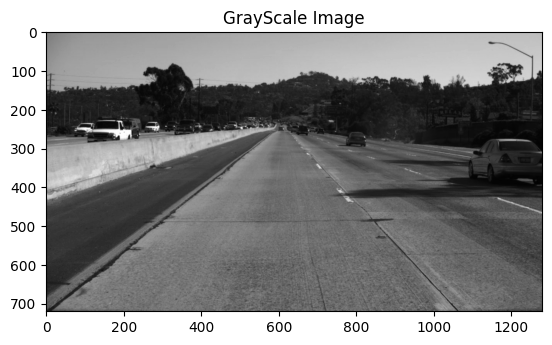

In [22]:
gray = convert_to_greyscale(image)
plt.title("GrayScale Image")
plt.imshow(gray, cmap='gray')

## Apply Gaussian Blur to Image

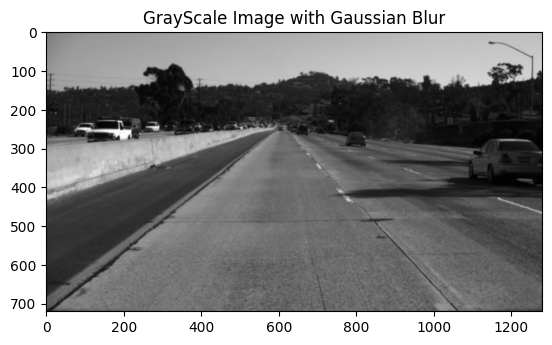

In [23]:
kernel_size = 5 
blur_gray = apply_gaussian_blur(gray, kernel_size)
plt.title("GrayScale Image with Gaussian Blur")
plt.imshow(blur_gray, cmap='gray')

## Apply Canny Transform

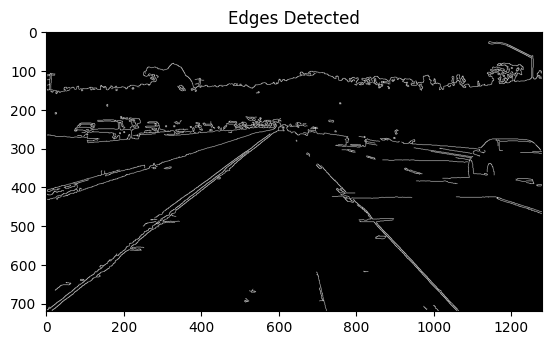

In [24]:
low_threshold = 50
high_threshold = 150

edges = apply_canny_transform(blur_gray, low_threshold, high_threshold)
plt.title("Edges Detected")
plt.imshow(edges, cmap='Greys_r')

## Apply Mask to Image

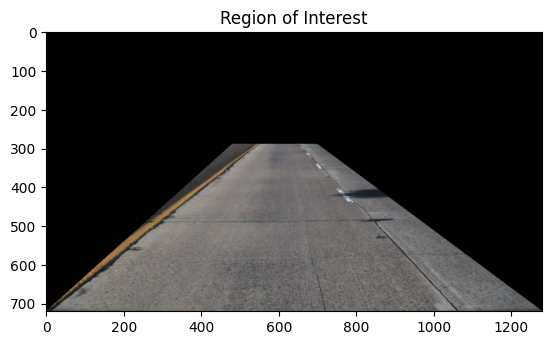

In [25]:
vertices = np.array([[(0,image.shape[0]),(480, 290), (700, 290), (image.shape[1],image.shape[0])]], dtype=np.int32)

mask = apply_mask(image, vertices)
plt.title("Region of Interest")
plt.imshow(mask, cmap='Greys_r')

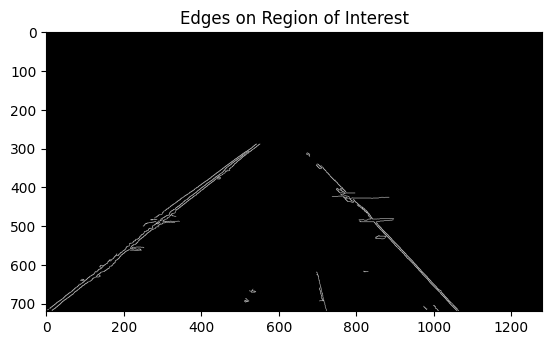

In [26]:
masked_edges = apply_mask(edges, vertices)
plt.title("Edges on Region of Interest")
plt.imshow(masked_edges, cmap='Greys_r')

## Use Hough Transform

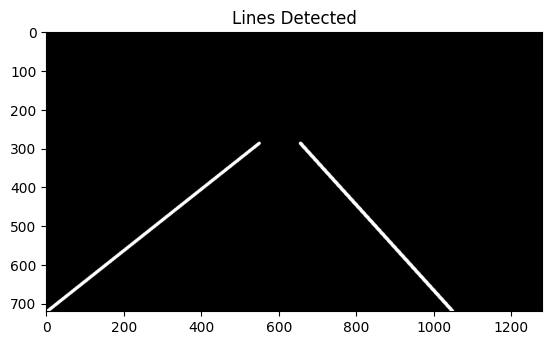

In [38]:
rho = 3
theta = np.pi/180
threshold = 15
min_line_len = 150
max_line_gap = 50

lines = hough_line_transformation(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
linesJpg = cv2.cvtColor(lines, cv2.COLOR_RGB2BGR)
plt.title("Lines Detected")
plt.imshow(linesJpg)

## Merge the lines onto the original image

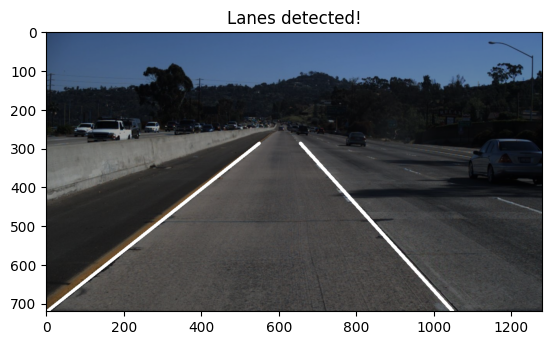

In [39]:
lines_edges = cv2.addWeighted(image, 0.8, linesJpg, 1, 0)
plt.title("Lanes detected!")
plt.imshow(lines_edges)

## Pipeline to process an image

In [40]:
# Pipeline for processing an image
def image_pipeline(file):
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    rho = 3
    theta = np.pi/180
    threshold = 15
    min_line_len = 150
    max_line_gap = 50
    

    # Read image from file
    image = mpimg.imread(file)

    # Convert image to grayscale
    grayscale_image = convert_to_greyscale(image)

    # Apply Gaussian blur
    gaussian = apply_gaussian_blur(grayscale_image, kernel_size)

    # Apply Canny transform
    canny = apply_canny_transform(gaussian, low_threshold, high_threshold)

    # Apply mask
    vertices = np.array([[(0,image.shape[0]),(480, 290), (700, 290), (image.shape[1],image.shape[0])]], dtype=np.int32)
    masked_image = apply_mask(canny, vertices)

    # Apply Hough Line Transformation
    hough = hough_line_transformation(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    lines = cv2.cvtColor(hough, cv2.COLOR_BGR2RGB)

    # Merge lines with original image
    merged_image = merge_lines_with_image(image, lines)

    return merged_image

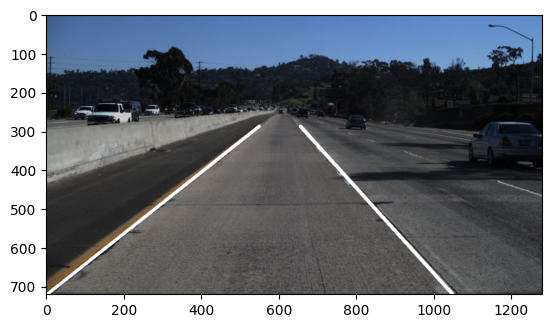

In [41]:
file = '../Dataset/Input/15.jpg'
image = image_pipeline(file)
plt.imshow(image)

## Pipeline to process a video

In [31]:
def video_pipeline(image):
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    rho = 3
    theta = np.pi/180
    threshold = 15
    min_line_len = 150
    max_line_gap = 50

    # Convert image to grayscale'
    grayscale_image = convert_to_greyscale(image)

    # Apply Gaussian blur
    gaussian = apply_gaussian_blur(grayscale_image, kernel_size)

    # Apply Canny transform
    canny = apply_canny_transform(gaussian, low_threshold, high_threshold)

    # Apply mask
    vertices = np.array([[(650,800),(950, 600), (1050, 600), (1300,800)]], dtype=np.int32)
    masked_image = apply_mask(canny, vertices)

    # Apply Hough Line Transformation
    hough = hough_line_transformation(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    lines = cv2.cvtColor(hough, cv2.COLOR_BGR2RGB)

    # Merge lines with original image
    merged_image = merge_lines_with_image(image, lines)

    plt.imshow(merged_image)
    return merged_image

Moviepy - Building video ../Dataset/Output/IMG_0267.mp4.
Moviepy - Writing video ../Dataset/Output/IMG_0267.mp4



Moviepy - Done !
Moviepy - video ready ../Dataset/Output/IMG_0267.mp4


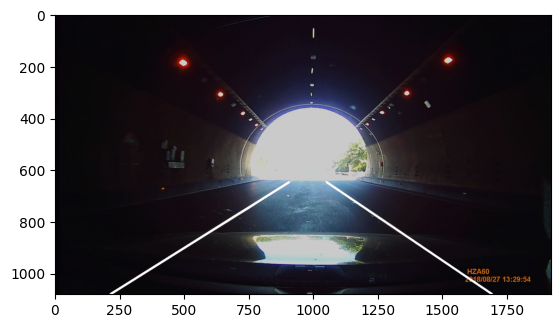

In [36]:
video_file = '../Dataset/Input/IMG_0267.MOV'
clip = VideoFileClip(video_file).subclip(0, 10)
video_output = clip.fl_image(video_pipeline)
video_output.write_videofile('../Dataset/Output/IMG_0267.mp4', audio=False)
